In [15]:
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
import numpy as np
import os
import random

In [16]:
# ----------------------------
# Settings
# ----------------------------
IMG_SIZE = (224, 224)  # Same as your preprocessing pipelines
dataset_dir = "./dataset/normal"  # Folder containing images

# Pick one random image from dataset/normal
all_images = [os.path.join(dataset_dir, f) for f in os.listdir(dataset_dir) if f.endswith(('.jpg','.jpeg','.png'))]
sample_path = random.choice(all_images)
print(f"Selected image: {sample_path}")

Selected image: ./dataset/normal\normal_0072.jpeg


In [17]:
# ----------------------------
# Helper functions
# ----------------------------
def show_image(img, title=""):
    """Display image with matplotlib"""
    plt.figure(figsize=(4,4))
    plt.imshow(img.astype(np.uint8))
    plt.title(title)
    plt.axis('off')
    plt.show()

def preprocess_1_image(path):
    img = tf.io.read_file(path)
    img = tf.io.decode_jpeg(img, channels=1)                 # grayscale
    img = tf.image.resize(img, IMG_SIZE)                     # resize
    img = tf.image.grayscale_to_rgb(img)                     # convert to RGB
    img = img.numpy().astype(np.uint8)                       # convert to uint8 for OpenCV
    return img

def preprocess_2_image(path):
    img = tf.io.read_file(path)
    img = tf.io.decode_jpeg(img, channels=1)
    img = tf.image.resize(img, IMG_SIZE)
    img = tf.image.grayscale_to_rgb(img)
    img = tf.keras.applications.mobilenet_v2.preprocess_input(img)  # normalize [-1,1]
    img = ((img + 1) * 127.5).numpy().astype(np.uint8)              # back to [0,255] for visualization
    return img

def apply_clahe(img):
    # Ensure uint8
    if img.dtype != np.uint8:
        img = (img * 255).astype(np.uint8)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    clahe_img = clahe.apply(gray)
    img = cv2.cvtColor(clahe_img, cv2.COLOR_GRAY2RGB)
    return img

def apply_denoise_clahe(img):
    # Ensure uint8
    if img.dtype != np.uint8:
        img = (img * 255).astype(np.uint8)
    img = cv2.fastNlMeansDenoisingColored(img, None, 10, 10, 7, 21)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    clahe_img = clahe.apply(gray)
    img = cv2.cvtColor(clahe_img, cv2.COLOR_GRAY2RGB)
    return img

def normalize(img):
    img = img.astype("float32") / 255.0
    img = (img * 255).astype(np.uint8)  # for visualization
    return img


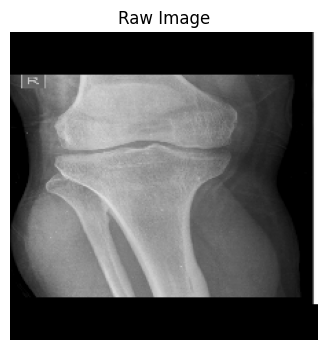

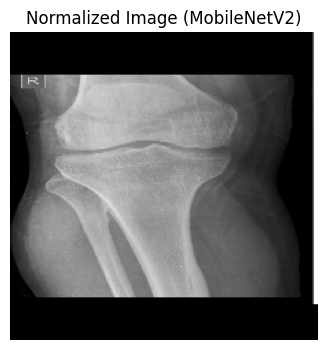

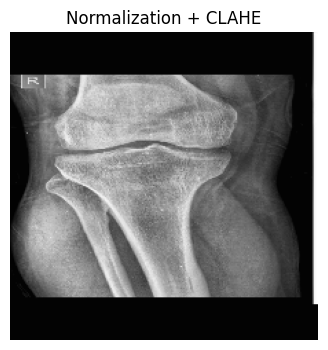

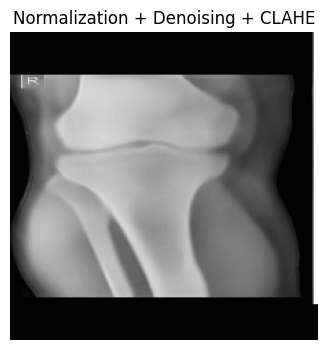

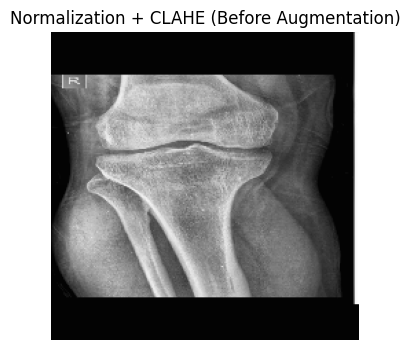

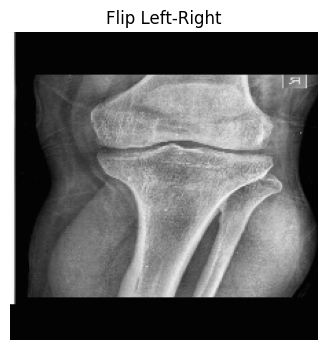

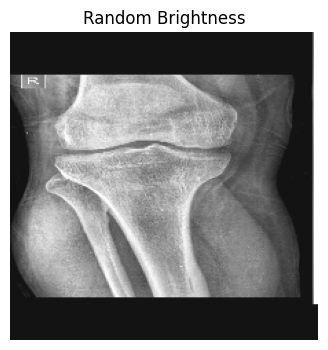

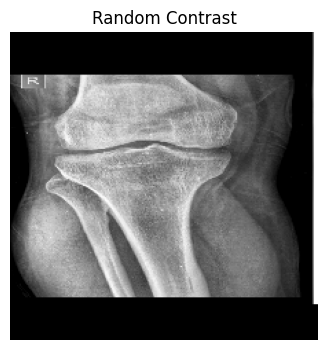

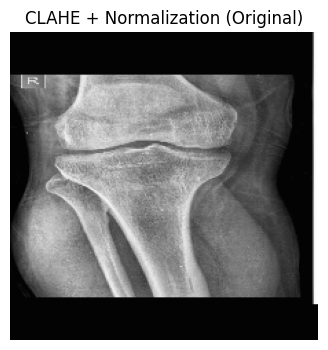

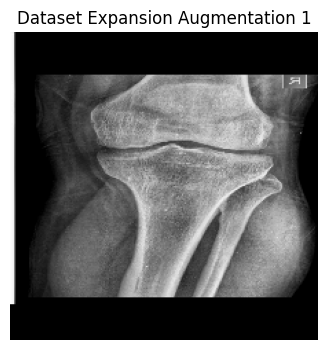

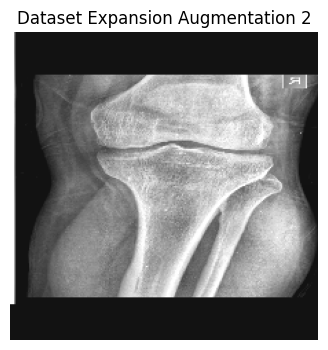

In [18]:
# ----------------------------
# Visualization of Preprocessing Steps
# ----------------------------

# --- Raw Image ---
raw_img = preprocess_1_image(sample_path)
show_image(raw_img, "Raw Image")

# --- Pipeline 2: Normalization (MobileNetV2) ---
norm_img = preprocess_2_image(sample_path)
show_image(norm_img, "Normalized Image (MobileNetV2)")

# --- Pipeline 3: Normalization + CLAHE ---
img3 = preprocess_1_image(sample_path)
img3 = normalize(img3)   # scale to [0,1] then back to 0-255 for visualization
img3 = apply_clahe(img3)
show_image(img3, "Normalization + CLAHE")

# --- Pipeline 4: Normalization + Denoising + CLAHE ---
img4 = preprocess_1_image(sample_path)
img4 = normalize(img4)
img4 = apply_denoise_clahe(img4)
show_image(img4, "Normalization + Denoising + CLAHE")

# --- Pipeline 5: Normalization + CLAHE + Data Augmentation ---
img5 = preprocess_1_image(sample_path)
img5 = normalize(img5)
img5 = apply_clahe(img5)
show_image(img5, "Normalization + CLAHE (Before Augmentation)")

# Individual augmentations
aug_flip = tf.image.random_flip_left_right(img5).numpy()
show_image(aug_flip, "Flip Left-Right")

aug_bright = tf.image.random_brightness(img5, max_delta=0.1).numpy()
show_image(aug_bright, "Random Brightness")

aug_contrast = tf.image.random_contrast(img5, 0.9, 1.1).numpy()
show_image(aug_contrast, "Random Contrast")

# --- Pipeline 6: CLAHE + Normalization + Augmentation + Dataset Expansion ---
img6 = preprocess_1_image(sample_path)
img6 = apply_clahe(img6)
img6 = normalize(img6)
show_image(img6, "CLAHE + Normalization (Original)")

# Dataset expansion augmentations
num_aug = 2
for i in range(num_aug):
    aug = tf.image.random_flip_left_right(img6)
    aug = tf.image.random_brightness(aug, max_delta=0.1)
    aug = tf.image.random_contrast(aug, 0.9, 1.1)
    aug_img = aug.numpy()
    show_image(aug_img, f"Dataset Expansion Augmentation {i+1}")